# Vector Autoregressions

## Imports

In [2]:
# Linear Algebram, Data Manipulation
import numpy as np
import pandas as pd

# Plots
import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib import dates
import mplfinance as mpf
import statsmodels.api as sm
from statsmodels.tsa.stattools import adfuller

import chart_studio.plotly as py
import plotly.express as px
import plotly.graph_objects as go

# Ignore Warnings
import warnings
warnings.filterwarnings("ignore")

## Augmented Dickey-Fuller

In [22]:
def adf_test(timeseries):
    print("Dickey-Fuller Test")
    dftest = adfuller(timeseries, autolag="AIC")
    dfoutput = pd.Series(dftest[0:4], index=["Tes Statistic", 'p-value', "#Lags Used", "Number of Observations Used"])
    print(dfoutput, "\n\n")

- Vector autoregressive Models : Used to Predict Multiple Time Series
- Have to Check for Stationarity
- Make the Data Stationary and Invert it Back
- use AIC to Measure our Model

In [15]:
from statsmodels.tsa.api import VAR

gdp_df = pd.read_csv("./datasets/gdp-data.csv", index_col="date", parse_dates=True)
gdp_df = gdp_df[gdp_df.index < "2020-03-31"]
gdp_df = gdp_df.dropna()
gdp_df = gdp_df.asfreq("Q")

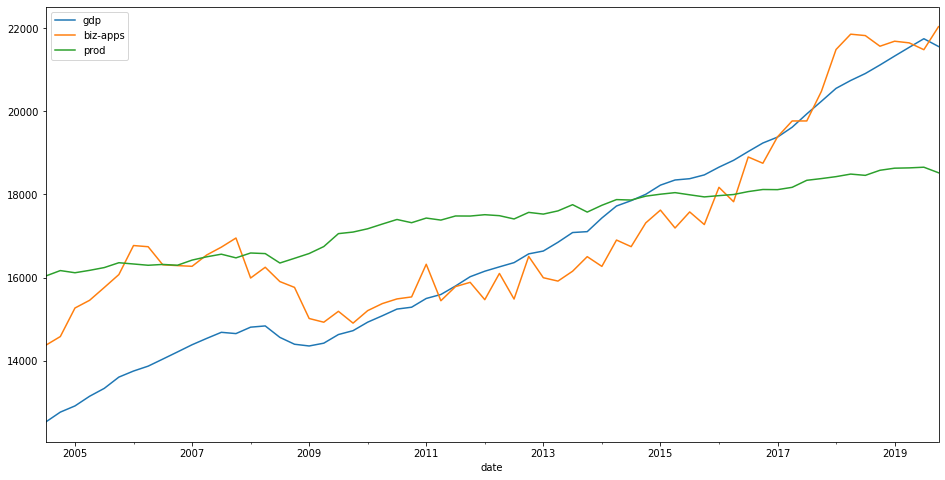

In [16]:
gdp_df["biz-apps"] = gdp_df["biz-apps"] * 0.025
gdp_df["prod"] = gdp_df["prod"] * 180

gdp_df["gdp"].plot(legend=True, figsize=(16, 8))
gdp_df["biz-apps"].plot(legend=True)
gdp_df["prod"].plot(legend=True)

plt.show()

## Make Data Stationary

In [20]:
gdp_diff_df = gdp_df.diff()
gdp_diff_df.dropna(inplace=True)
gdp_diff_df

,gdp,biz-apps,prod
date,,,
2004-12-31,238.912,210.650,131.4
2005-03-31,148.685,686.525,-52.2
2005-06-30,232.851,185.750,57.6
2005-09-30,189.443,307.200,66.6
2005-12-31,271.617,312.225,117.0
...,...,...,...
2018-12-31,205.456,-256.300,122.4
2019-03-31,214.568,120.575,50.4
2019-06-30,210.448,-39.700,7.2


<AxesSubplot:xlabel='date'>

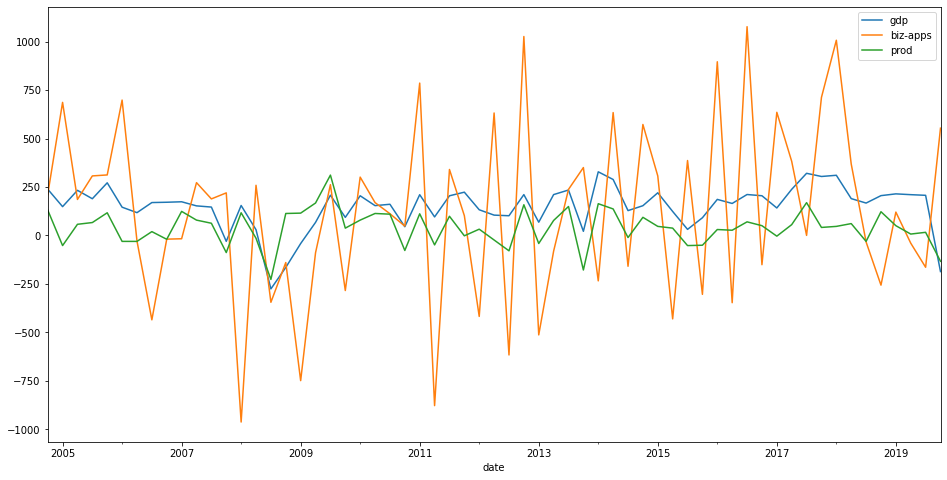

In [21]:
gdp_diff_df.plot(legend=True, figsize=(16, 8))

## Checking if Data is Stationay by Using Dickey-Fuller Test

In [23]:
adf_test(gdp_diff_df["gdp"])

adf_test(gdp_diff_df["biz-apps"])

adf_test(gdp_diff_df["prod"])

Dickey-Fuller Test
Tes Statistic                  -4.231840
p-value                         0.000582
#Lags Used                      0.000000
Number of Observations Used    60.000000
dtype: float64 


Dickey-Fuller Test
Tes Statistic                  -4.847785
p-value                         0.000044
#Lags Used                      1.000000
Number of Observations Used    59.000000
dtype: float64 


Dickey-Fuller Test
Tes Statistic                 -8.342130e+00
p-value                        3.155371e-13
#Lags Used                     0.000000e+00
Number of Observations Used    6.000000e+01
dtype: float64 




## Train and Test

In [24]:
train_df = gdp_diff_df.iloc[:146]
test_df = gdp_diff_df.iloc[146:]

In [25]:
model = VAR(train_df)

for p in range(1, 8):
    res = model.fit(p)
    print(f"Order : {p}, AIC : {res.aic}")

Order : 1, AIC : 29.430765695054923
Order : 2, AIC : 29.506892530237966
Order : 3, AIC : 29.574206262492687
Order : 4, AIC : 29.774732348897363
Order : 5, AIC : 29.82451544493755
Order : 6, AIC : 29.934526666082753
Order : 7, AIC : 29.995411157086057


In [26]:
res = model.fit(1)
res.summary()

  Summary of Regression Results   
Model:                         VAR
Method:                        OLS
Date:           Mon, 25, Oct, 2021
Time:                     19:03:19
--------------------------------------------------------------------
No. of Equations:         3.00000    BIC:                    29.8496
Nobs:                     60.0000    HQIC:                   29.5946
Log likelihood:          -1126.33    FPE:                6.05170e+12
AIC:                      29.4308    Det(Omega_mle):     4.98644e+12
--------------------------------------------------------------------
Results for equation gdp
                 coefficient       std. error           t-stat            prob
------------------------------------------------------------------------------
const              65.707462        24.205971            2.715           0.007
L1.gdp              0.634429         0.158564            4.001           0.000
L1.biz-apps        -0.010715         0.031128           -0.344        

## Plotting

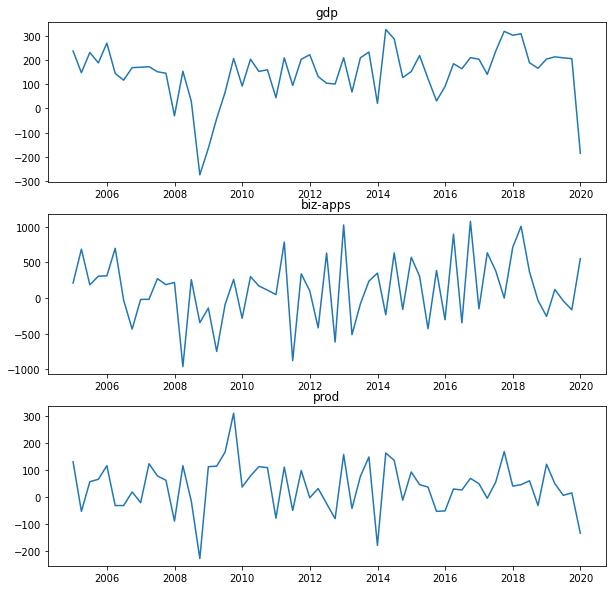

In [28]:
res.plot();

## Forecasting

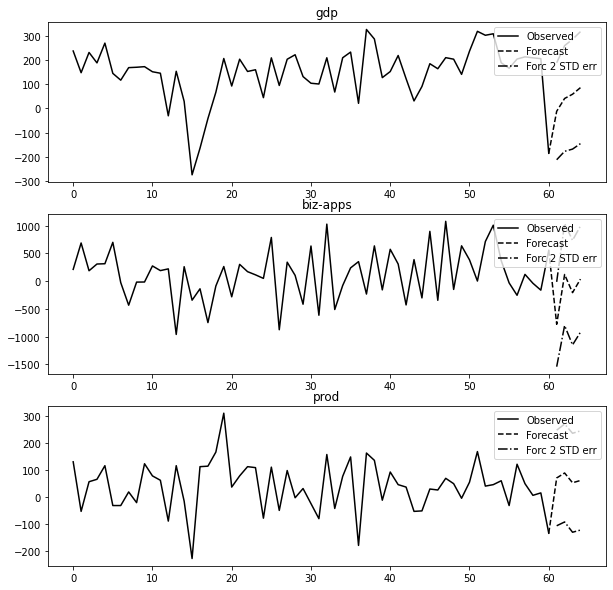

In [31]:
forecast_res = res.forecast(gdp_diff_df.values[-1:], 4)
res.plot_forecast(4);

## Setup Dataframe with Forecast Data

In [32]:
indx = pd.date_range("6/30/2020", periods=4, freq="Q-DEC")
forecast_df = pd.DataFrame(forecast_res, index=indx, columns=["f-gdp", "f-biz-apps", "f-prod"])
forecast_df

,f-gdp,f-biz-apps,f-prod
2020-06-30,-11.649082,-779.058239,71.495463
2020-09-30,41.576289,118.196268,89.948953
2020-12-31,59.255006,-208.639970,53.757967
2021-03-31,86.672287,34.852294,62.252630


## Undoing the Difference

In [34]:
ex_df = pd.DataFrame({"A": np.random.randint(0, 10, 5)})
ex_df["B"] = ex_df["A"].diff()
ex_df

,A,B
0,4,NaN
1,5,1.0
2,9,4.0
3,6,-3.0
4,9,3.0


In [36]:
x, x_diff = ex_df["A"].iloc[0], ex_df["B"].iloc[1:]
ex_df["C"] = np.r_[x, x_diff].cumsum().astype(float)
ex_df

,A,B,C
0,4,NaN,4.0
1,5,1.0,5.0
2,9,4.0,9.0
3,6,-3.0,6.0
4,9,3.0,9.0


<AxesSubplot:>

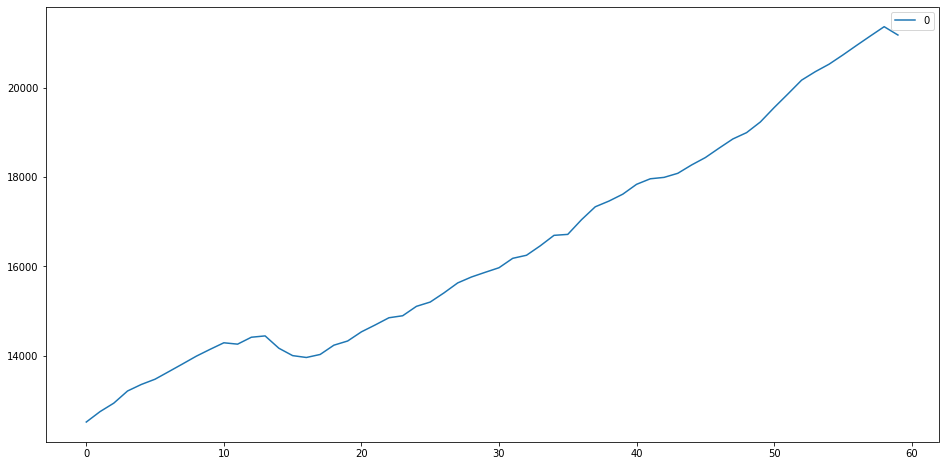

In [39]:
x, x_diff = gdp_df["gdp"].iloc[0], gdp_diff_df["gdp"].iloc[2:]
n_gdp_df = pd.DataFrame(np.r_[x, x_diff].cumsum().astype(float))
n_gdp_df.append(forecast_df["f-gdp"].cumsum())

n_gdp_df.plot(figsize=(16, 8))